In [1]:
import torch
from torch.utils.data import Dataset
import cv2
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import h5py

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
train_data1 = pd.read_pickle("data/train_data_44525_Ynet.pkl")
train_data2 = pd.read_pickle("data/train_data_44522_Ynet.pkl")
train_data3 = pd.read_pickle("data/train_data_50631_Ynet.pkl")

train_data = pd.concat([train_data1, train_data2, train_data3], ignore_index=True)

del train_data1, train_data2, train_data3

In [5]:
train_df, val_df = train_test_split(train_data, test_size = 0.1)

train_X, train_ref, train_Y = train_df['train_X'], train_df['train_ref'], train_df['train_Y']
val_X, val_ref, val_Y = val_df['train_X'], val_df['train_ref'], val_df['train_Y']

Train set size : 3746 	 Validation set size : 417
(155, 272) (155, 272)


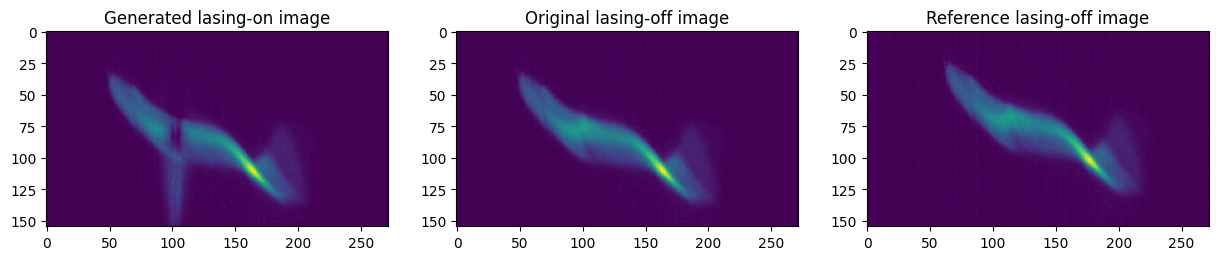

In [12]:
print(f"Train set size : {train_X.shape[-1]} \t Validation set size : {val_X.shape[-1]}")
idx = 3220
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(train_X[idx])
ax[0].set_title("Generated lasing-on image")
ax[1].imshow(train_Y[idx])
ax[1].set_title("Original lasing-off image")
ax[2].imshow(train_ref[idx])
ax[2].set_title("Reference lasing-off image")

print(train_X[idx].shape, train_Y[idx].shape)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 30
LR = 1e-4
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200
BATCH_SIZE = 32

In [14]:
import albumentations as alb

def get_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
      ], is_check_shapes=False)

def get_val_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
      ], is_check_shapes=False)

In [15]:
class LasingDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = row.train_X
        ref = row.train_ref
        mask = row.train_Y


        if self.augmentations:
            data = self.augmentations(image = image) 
            image = data['image']
            data = self.augmentations(image = mask)
            mask = data['image']
            data = self.augmentations(image = ref)
            ref = data['image']

        image_on = np.expand_dims(image, axis=0)
        image_off = np.expand_dims(mask, axis=0)
        image_ref = np.expand_dims(ref, axis=0)

        return image_on, image_ref, image_off

In [16]:
trainset = LasingDataset(train_df, get_augs())
valset = LasingDataset(val_df, get_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 3746
Size of Validset : 417


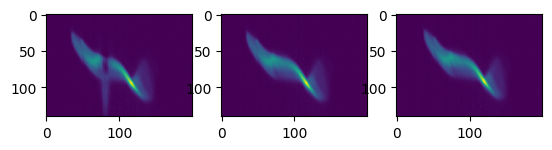

In [22]:
idx = 600
image_on, image_ref, image_off = trainset[idx]
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_on[0])
ax[1].imshow(image_off[0])
ax[2].imshow(image_ref[0])

In [23]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = False)
valloader = DataLoader(valset, batch_size= BATCH_SIZE)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:

class YNet(nn.Module):
    def __init__(self):
        super(YNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
               # nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder for input image
        self.input_conv0 = CBR(1, 32)
        self.input_conv1 = CBR(32, 64)
        self.input_conv2 = CBR(64, 64)
        self.input_pool1 = nn.MaxPool2d(2, 2)
        self.input_conv3 = CBR(64, 128)
        self.input_conv4 = CBR(128, 128)
        self.input_pool2 = nn.MaxPool2d(2, 2)
        
        # Encoder for reference image
        self.ref_conv0 = CBR(1, 32)
        self.ref_conv1 = CBR(32, 64)
        self.ref_conv2 = CBR(64, 64)
        self.ref_pool1 = nn.MaxPool2d(2, 2)
        self.ref_conv3 = CBR(64, 128)
        self.ref_conv4 = CBR(128, 128)
        self.ref_pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck_conv1 = CBR(256, 256)
        self.bottleneck_conv2 = CBR(256, 256)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder_conv1 = CBR(256, 128)
        self.decoder_conv2 = CBR(128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder_conv3 = CBR(128, 64)
        self.decoder_conv4 = CBR(64, 32)
        self.output_conv = nn.Conv2d(32, 1, 1)
        
    def forward(self, input_img, ref_img):
        # Encode input image
        enc1_input = self.input_conv0(input_img)
        enc2_input = self.input_conv1(enc1_input)
        enc2_input = self.input_conv2(enc2_input)
        enc3_input = self.input_pool1(enc2_input)
        enc3_input = self.input_conv3(enc3_input)
        enc3_input = self.input_conv4(enc3_input)
        enc4_input = self.input_pool2(enc3_input)
        
        # Encode reference image
        enc1_ref = self.ref_conv0(ref_img)
        enc2_ref = self.ref_conv1(enc1_ref)
        enc2_ref = self.ref_conv2(enc2_ref)
        enc3_ref = self.ref_pool1(enc2_ref)
        enc3_ref = self.ref_conv3(enc3_ref)
        enc3_ref = self.ref_conv4(enc3_ref)
        enc4_ref = self.ref_pool2(enc3_ref)
        
        # Concatenate features at the bottleneck
        bottleneck_input = torch.cat((enc4_input, enc4_ref), dim=1)
        bottleneck_output = self.bottleneck_conv1(bottleneck_input)
        bottleneck_output = self.bottleneck_conv2(bottleneck_output)
        
        # Decoder
        dec1 = self.upconv1(bottleneck_output)
        dec1 = torch.cat((dec1, enc3_input), dim=1)
        dec1 = self.decoder_conv1(dec1)
        dec1 = self.decoder_conv2(dec1)
        
        dec2 = self.upconv2(dec1)
        dec2 = torch.cat((dec2, enc2_input), dim=1)
        dec2 = self.decoder_conv3(dec2)
        dec2 = self.decoder_conv4(dec2)
        
        output = self.output_conv(dec2)
        return output

# Instantiate the model
model = YNet()
#print(model)

In [26]:
def train_function(data_loader, model, criterion, optimizer):

    model.train()
    total_loss = 0.0

    for inputs, references, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        references = references.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, references)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_function(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, references, targets in tqdm(data_loader):
            inputs = inputs.to(device)
            references = references.to(device)
            targets = targets.to(device)

            outputs = model(inputs, references)

            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(data_loader)


In [ ]:
#model = UNet()

Train = True

if Train:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Training loop
    EPOCHS = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = np.Inf

    train_L, val_L = [], []
    for i in range(EPOCHS):

        train_loss = train_function(trainloader, model, criterion, optimizer)
        train_L.append(train_loss)
        val_loss = eval_function(valloader, model)
        val_L.append(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f'best_model{timestamp}.pt')
            best_val_loss = val_loss

        print(f"Epoch: {i+1}   Train loss: {train_loss}  Val_loss: {val_loss}")
    
    state_dict = torch.load("best_model.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    
    plt.plot(train_L, label="train loss")
    plt.plot(val_L, label="test loss")
    plt.legend()

else:
    
    model = UNet()
    state_dict = torch.load("best_model_yet.pt")
    model.load_state_dict(state_dict)
    model.to(device)
        

100%|██████████| 14/14 [00:01<00:00,  9.16it/s]


Epoch: 1   Train loss: 0.0005999085282136379  Val_loss: 0.00024398952934591631


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


Epoch: 2   Train loss: 0.00018870074699546004  Val_loss: 0.00020550194572673978


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 3   Train loss: 0.0001729380950317876  Val_loss: 0.00016739080300404957


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 4   Train loss: 0.00016823301188720753  Val_loss: 0.00016007522000498802


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 5   Train loss: 0.0001646785007077427  Val_loss: 0.00015918331908843747


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 6   Train loss: 0.00016268371602903137  Val_loss: 0.00016022447172352777


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 7   Train loss: 0.00016143325601814914  Val_loss: 0.00016017861344153062


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 8   Train loss: 0.00016041466012011062  Val_loss: 0.00015863316574333503


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 9   Train loss: 0.0001598528853441999  Val_loss: 0.0001574483524434202


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


Epoch: 10   Train loss: 0.00015923954844642509  Val_loss: 0.00015539534537570683


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 11   Train loss: 0.00015802595188981318  Val_loss: 0.00016877210821673674


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


Epoch: 12   Train loss: 0.00015906340056478827  Val_loss: 0.00015728071749825695


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch: 15   Train loss: 0.00015593064692778064  Val_loss: 0.00016706966822052242


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch: 16   Train loss: 0.00015793704150675726  Val_loss: 0.00015831530514073426


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch: 17   Train loss: 0.0001567594516295762  Val_loss: 0.0001593170652215901


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch: 18   Train loss: 0.00015686914606303  Val_loss: 0.00015697796750048707


100%|██████████| 14/14 [00:01<00:00,  9.16it/s]


Epoch: 19   Train loss: 0.00015617910938059234  Val_loss: 0.00015737397396670922


100%|██████████| 14/14 [00:01<00:00,  9.15it/s]


Epoch: 20   Train loss: 0.00015583981920657205  Val_loss: 0.00015671754902411652


100%|██████████| 14/14 [00:01<00:00,  9.18it/s]


Epoch: 21   Train loss: 0.00015551046814480442  Val_loss: 0.0001620214939716139


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 22   Train loss: 0.00015606193954812686  Val_loss: 0.00016788366649832045


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 23   Train loss: 0.0001558356384289948  Val_loss: 0.0001750047080609615


100%|██████████| 14/14 [00:01<00:00,  9.15it/s]


Epoch: 24   Train loss: 0.0001566526811445128  Val_loss: 0.00017946236299134659


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 44   Train loss: 0.0001559464302988352  Val_loss: 0.00019102689475403167


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 45   Train loss: 0.00015545836905110231  Val_loss: 0.00019022304072028158


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


Epoch: 46   Train loss: 0.00015520689466014164  Val_loss: 0.00016433567881384597


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 47   Train loss: 0.0001551918941019675  Val_loss: 0.00019225708976071992


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 48   Train loss: 0.00015522576121823522  Val_loss: 0.00018297803451007764


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 49   Train loss: 0.0001545316561964297  Val_loss: 0.00018857251208308817


100%|██████████| 14/14 [00:01<00:00,  9.23it/s]


Epoch: 50   Train loss: 0.00015704346530537035  Val_loss: 0.0001817980555642862


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 51   Train loss: 0.00015410137477713654  Val_loss: 0.00018194498833119205


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


Epoch: 52   Train loss: 0.00015404423264321927  Val_loss: 0.00018453286403590546


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 53   Train loss: 0.00015444815154157785  Val_loss: 0.00017946326988749206


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 54   Train loss: 0.0001537486520446383  Val_loss: 0.00016945934943838177


100%|██████████| 14/14 [00:01<00:00,  9.20it/s]


Epoch: 55   Train loss: 0.00015616614562809523  Val_loss: 0.00019134730609948747


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 56   Train loss: 0.00015462068444383292  Val_loss: 0.00019840071971494972


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 57   Train loss: 0.0001566603343728614  Val_loss: 0.00019246124897368385


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


Epoch: 58   Train loss: 0.00015454964094545684  Val_loss: 0.00017575097652817412


100%|██████████| 14/14 [00:01<00:00,  9.19it/s]


Epoch: 65   Train loss: 0.00015317496671109516  Val_loss: 0.00019411524512439167


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch: 66   Train loss: 0.00015284568403099694  Val_loss: 0.00018536196980026683


100%|██████████| 14/14 [00:01<00:00,  9.18it/s]


Epoch: 67   Train loss: 0.00016451016843779668  Val_loss: 0.00019616643839981407


 67%|██████▋   | 79/118 [00:25<00:12,  3.14it/s]

In [40]:
def model_pred(model, img, ref, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    ref = (ref / np.max(ref)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    ref = cv2.medianBlur(ref, kernel_size)
    
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    ref = cv2.resize(ref, (N, M))
    
    data = get_augs()(image = img)
    img = data['image']
    
    data = get_augs()(image = ref)
    ref = data['image']
    
    img = np.expand_dims(img, axis=0)
    ref = np.expand_dims(ref, axis=0)
    
    testX = torch.tensor(img).to(device)
    test_ref = torch.tensor(ref).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0), test_ref.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred

def plot_power_profile(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    T = np.linspace(0, len(power_px), len(power_px)) * dT
    E = np.linspace(0, pred_in.shape[0], pred_in.shape[0]) * dE
    E -= np.mean(E)
    
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})#, sharex=True)

    #ax[0].contourf(T, E, np.flip(np.array(pred_in), axis=0), 100)
    ax[0].imshow(pred_in, cmap='turbo', aspect='auto')
    ax[0].plot(mean_px_sase_on , alpha=0.5)
    ax[0].plot(mean_px_sase_off, alpha=0.5)
    ax[0].set_xticklabels([])  # Hide x tick labels

    ax[1].plot(T, power, label = "power profile from mean") #, alpha=0.8)
    ax[1].set_xlim(min(T), max(T))
    ax[1].set_xlabel("t (fs)")
    ax[1].set_ylabel("dE (MeV)")
    #plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
    #plt.legend()
    
    return np.array(power)

In [41]:
val_inp = [inputs for inputs, refs, outputs in valloader]
val_out = [outputs for inputs, refs, outputs in valloader]
val_ref = [refs for inputs, refs, outputs in valloader]

train_inp = [inputs for inputs, refs, outputs in trainloader]
train_out = [outputs for inputs, refs, outputs in trainloader]
train_ref = [refs for inputs, refs, outputs in trainloader]

In [ ]:
idx = 2
valX = val_inp[3][idx]
valRef = val_ref[3][idx].to(device)
valX = valX.to(device)
valY = val_out[3][idx]

model.eval()
with torch.no_grad():
    val_pred = model(valX.unsqueeze(0), valRef.unsqueeze(0))
    
valX = valX.squeeze().cpu()
valY = valY.squeeze().cpu()
val_pred = val_pred.squeeze().cpu()

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(valX)
ax[0].set_title("input")
ax[1].imshow(val_pred)
ax[1].set_title("prediction")
ax[2].imshow(valY)
ax[2].set_title("original image")

Text(0.5, 1.0, 'original image')

In [46]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50630}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        img_in = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1])

In [47]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50631}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        img_ref = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1])

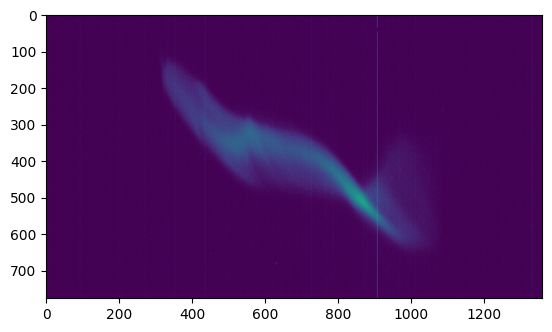

In [48]:
plt.imshow(img_ref)

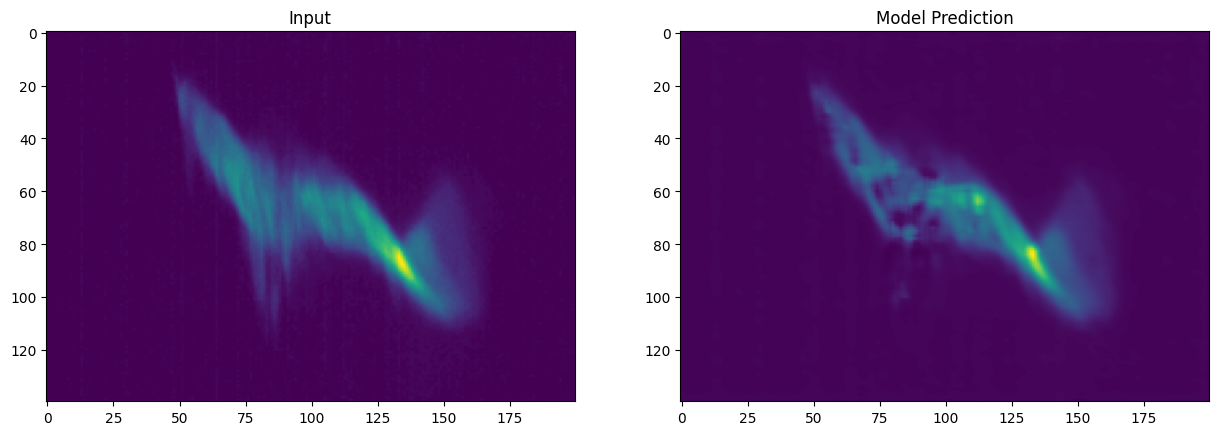

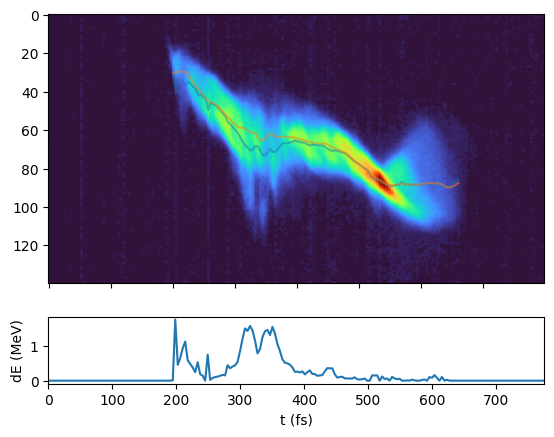

In [49]:
dE = 776 * 0.030 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, img_in, img_ref, plot=True)
power_px = plot_power_profile(pred_in, pred_out, dE, dT)

In [36]:
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44525}*20230302*')[0]

with h5py.File(filestr,'r') as fi:
        img_in = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][2][600:1200,200:1800])
        
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44525}*20230302*')[18]

with h5py.File(filestr,'r') as fi:
        img_ref = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1][600:1200,200:1800])
    

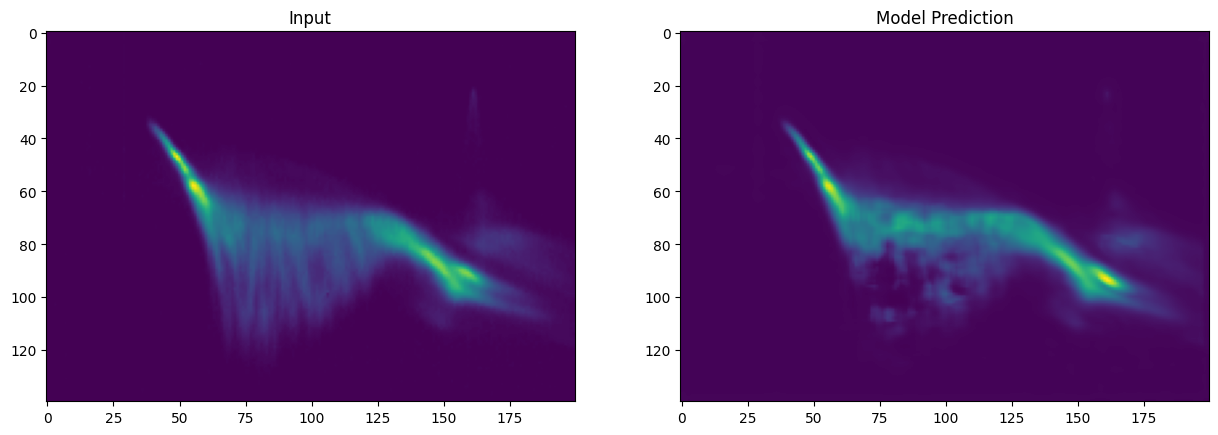

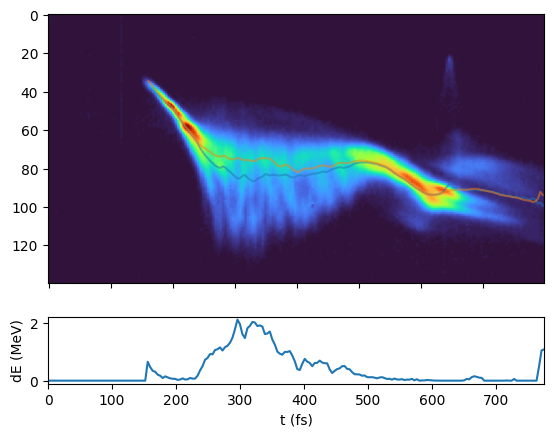

In [37]:
dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, img_in, img_ref, plot=True)
power_px = plot_power_profile(pred_in, pred_out, dE, dT)